### Data Science
### Módulo 2 _ Machine Learning
### Aprendizaje no supervisado

# Clusterización Jerárquica - Clustering
### `Skillsforindustry.org`


In [ ]:
# Tratamiento de datos
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

## Dataset

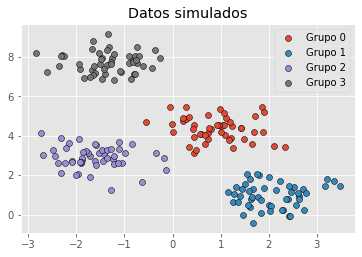

In [ ]:
# Simulación de datos

X, y = make_blobs(
        n_samples    = 200, 
        n_features   = 2, 
        centers      = 4, 
        cluster_std  = 0.60, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
ax.set_title('Datos simulados')
ax.legend();

### Modelo

Con la clase `sklearn.cluster.AgglomerativeClustering` de Scikit-Learn se pueden entrenar modelos de clustering utilizando el algoritmo hierarchical clustering aglomerativo. Entre sus parámetros destacan:

* `n_clusters`: determina el número de clusters que se van a generar. En su lugar, su valor puede ser `None` si se quiere utilizar el criterio `distance_threshold` para crear los clusters o crecer todo el dendograma.

* `distance_threshold`: distancia (altura del dendograma) a partir de la cual se dejan de unir los clusters. Indicar `distance_threshold=0` para crecer todo el árbol.

* `compute_full_tree`: si se calcula la jerarquía completa de clusters. Debe ser `True` si `distance_threshold` es distinto de `None`.

* `affinity`: métrica utilizada como distancia. Puede ser: “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. Si se utiliza `linkage=“ward”`, solo se permite “euclidean”.

* `linkage`: tipo de linkage utilizado. Puede ser “ward”, “complete”, “average” o “single”.

Al aplicar un hierarchical clustering aglomerativo se tiene que escoger una medida de distancia y un tipo de linkage. A continuación, se comparan los resultados con los linkages complete, ward y average, utilizando la distancia euclídea como métrica de similitud.

In [ ]:
# Escalado de datos
X_scaled = scale(X)

In [ ]:
# Modelos

modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X=X_scaled)

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X=X_scaled)

modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=X_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

¿Por qué se escalan los dato?

## Dendrogramas


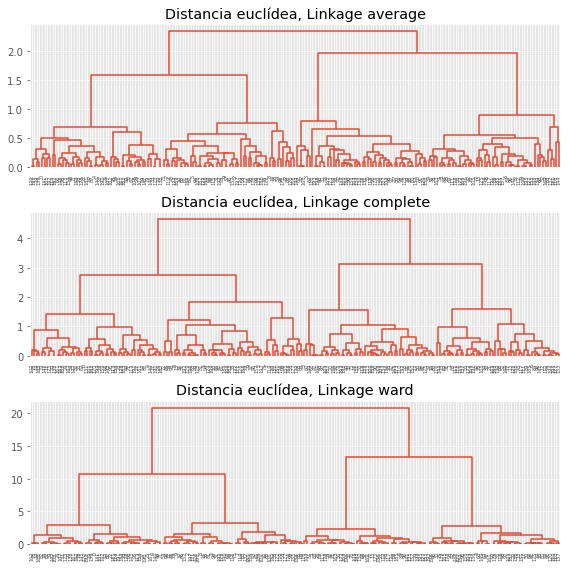

In [ ]:
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

En este caso, los tres tipos de linkage identifican claramente 4 clusters, si bien esto no significa que en los 3 dendrogramas los clusters estén formados por exactamente las mismas observaciones.


## Número de clusters



Una forma de identificar el número de clusters, es inspeccionar visualmente el dendograma y decidir a qué altura se corta para generar los clusters. Por ejemplo, para los resultados generados mediante distancia euclídea y **linkage ward**, parece sensato cortar el dendograma a una altura de entre 5 y 10, de forma que se creen 4 clusters.



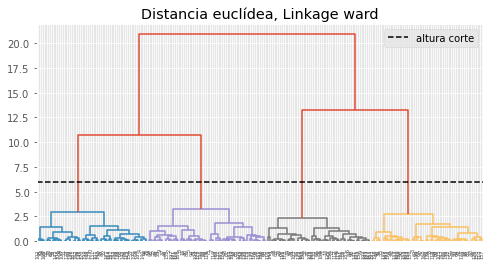

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 6
plot_dendrogram(modelo_hclust_ward, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Otra forma de identificar potenciales valores óptimos para el número de clusters en modelos hierarchical clustering es mediante los índices silhouette.



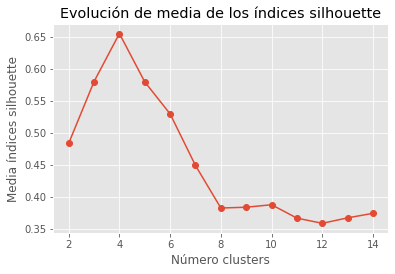

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Una vez identificado el número óptimo de clusters, se reentrena el modelo indicando este valor.



In [ ]:
# Modelo
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters = 4
                     )
modelo_hclust_ward.fit(X=X_scaled)

AgglomerativeClustering(n_clusters=4)